In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#The CIFAR-10 dataset
*  The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

* The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class.

* The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Classes
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
print(f"Training data shape: {x_train.shape}, Labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (50000, 32, 32, 3), Labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Labels shape: (10000, 1)


In [ ]:
print(f"Image pixel range: {x_train.min()} to {x_train.max()}")
print(f"Unique classes in train labels: {np.unique(y_train)}")


Image pixel range: 0 to 255
Unique classes in train labels: [0 1 2 3 4 5 6 7 8 9]


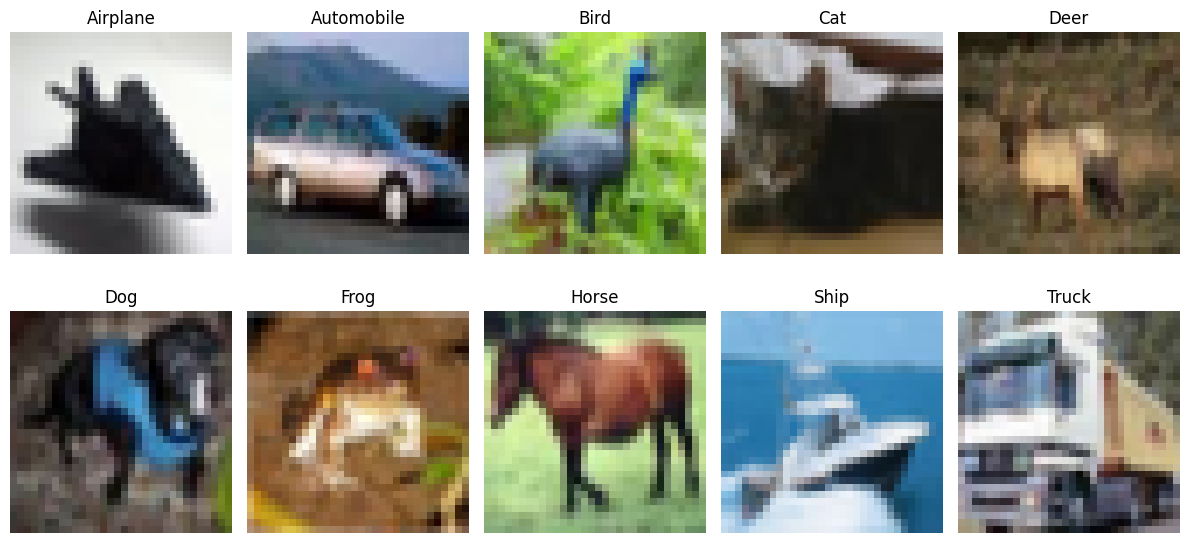

In [ ]:
# Display 10 random images, one from each class
plt.figure(figsize=(12, 6))
for i in range(10):
    idx = np.where(y_train.flatten() == i)[0][0]  # Get the first image of each class
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


**Class Distribution**

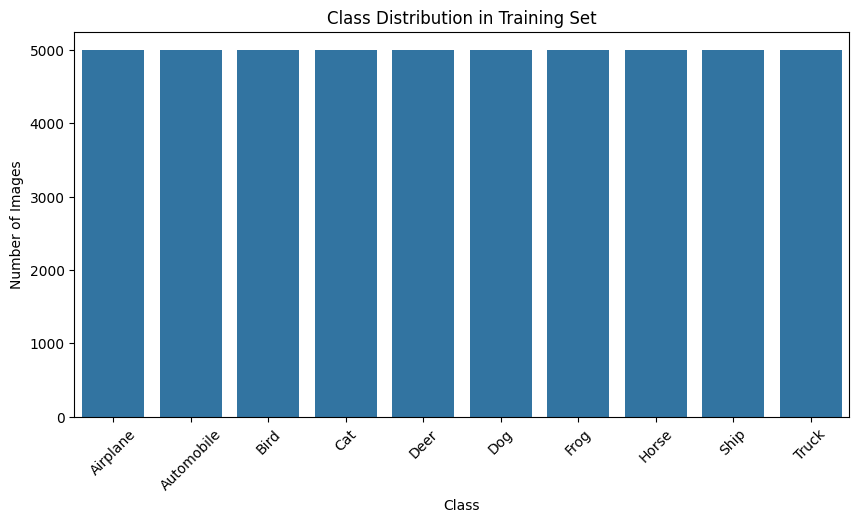

Training set class counts: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Test set class counts: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [ ]:
# Count the number of samples per class in the training set
train_class_counts = np.bincount(y_train.flatten())
test_class_counts = np.bincount(y_test.flatten())

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=train_class_counts)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()

# Print class counts
print("Training set class counts:", train_class_counts)
print("Test set class counts:", test_class_counts)


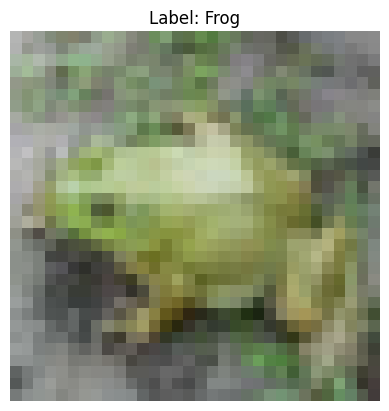

In [ ]:
# Display image and its corresponding label
idx = np.random.randint(0, len(x_train))  # Randomly select an index
plt.imshow(x_train[idx])
plt.title(f"Label: {class_names[y_train[idx][0]]}")
plt.axis('off')
plt.show()


**Image Pixel Statistics**

In [ ]:
# Normalize the pixel values to range [0, 1]
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

# Calculate pixel mean and standard deviation
mean_pixel_value = np.mean(x_train_normalized, axis=(0, 1, 2))
std_pixel_value = np.std(x_train_normalized, axis=(0, 1, 2))

print(f"Mean pixel value: {mean_pixel_value}")
print(f"Standard deviation of pixel values: {std_pixel_value}")


Mean pixel value: [0.49139968 0.48215841 0.44653091]
Standard deviation of pixel values: [0.24703223 0.24348513 0.26158784]


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import ViTModel, ViTConfig
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset Class
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms for CIFAR-10
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])

# Load CIFAR-10 dataset
transform = get_transforms()
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True)

train_loader = DataLoader(CIFAR10Dataset(train_dataset, transform), batch_size=64, shuffle=True)
val_loader = DataLoader(CIFAR10Dataset(test_dataset, transform), batch_size=64, shuffle=False)

# Masked Autoencoder Class
class MaskedAutoencoder(nn.Module):
    def __init__(self, vit_model, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.vit = vit_model
        self.mask_ratio = mask_ratio
        self.decoder = nn.Linear(vit_model.config.hidden_size, vit_model.config.patch_size ** 2 * 3)

    def forward(self, x, mask=True):
        batch_size, _, height, width = x.shape
        patch_size = self.vit.config.patch_size

        # Flatten image into patches
        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(batch_size, 3, -1, patch_size * patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(batch_size, -1, patch_size * patch_size * 3)

        # Apply masking
        if mask:
            num_patches = patches.shape[1]
            num_masked = int(self.mask_ratio * num_patches)
            mask_indices = torch.randperm(num_patches)[:num_masked]
            patches[:, mask_indices, :] = 0

        # Encode using ViT
        encoded = self.vit(pixel_values=x).last_hidden_state

        # Decode masked patches
        decoded = self.decoder(encoded[:, 1:, :])

        grid_size = int((decoded.shape[1]) ** 0.5)
        decoded = decoded.view(batch_size, grid_size, grid_size, patch_size, patch_size, 3)
        decoded = decoded.permute(0, 5, 1, 3, 2, 4).contiguous()
        reconstructed = decoded.view(batch_size, 3, height, width)

        return reconstructed

# ViT-MAE Classification Model
class ViTMAEClassification(nn.Module):
    def __init__(self, mae_model, num_classes):
        super(ViTMAEClassification, self).__init__()
        self.mae = mae_model
        self.classifier = nn.Linear(mae_model.vit.config.hidden_size, num_classes)

    def forward(self, x):
        encoded = self.mae.vit(pixel_values=x).pooler_output
        return self.classifier(encoded)

# Initialize Models
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_cls_model = ViTMAEClassification(mae_model, num_classes=10).to(device)

# Optimizers and Losses
optimizer_mae = Adam(mae_model.parameters(), lr=1e-4)
criterion_mae = nn.MSELoss()
optimizer_cls = Adam(vitmae_cls_model.parameters(), lr=1e-4)
criterion_cls = CrossEntropyLoss()

# Pretraining with Accuracy
def pretrain_mae(model, loader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)
            optimizer.zero_grad()

            reconstructed = model(images, mask=True)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Pretrain Loss: {total_loss/len(loader):.4f}")

# Training Classification
def train_classification(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

# Validation Classification
def validate_classification(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

# Pretraining
pretrain_mae(mae_model, train_loader, optimizer_mae, criterion_mae, device, epochs=5)

# Fine-tuning
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_classification(vitmae_cls_model, train_loader, optimizer_cls, criterion_cls, device)
    val_loss, val_accuracy = validate_classification(vitmae_cls_model, val_loader, criterion_cls, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save the final model
torch.save(vitmae_cls_model.state_dict(), "vit_mae_cifar10_model.pth")
print("Model saved successfully!")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Pretrain Loss: 0.1400
Epoch 2/15, Pretrain Loss: 0.0088
Epoch 3/15, Pretrain Loss: 0.0044


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import ViTModel, ViTConfig
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset Class
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms for CIFAR-10
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])

# Load CIFAR-10 dataset
transform = get_transforms()
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True)

train_loader = DataLoader(CIFAR10Dataset(train_dataset, transform), batch_size=64, shuffle=True)
val_loader = DataLoader(CIFAR10Dataset(test_dataset, transform), batch_size=64, shuffle=False)

# Masked Autoencoder Class
class MaskedAutoencoder(nn.Module):
    def __init__(self, vit_model, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.vit = vit_model
        self.mask_ratio = mask_ratio
        self.decoder = nn.Linear(vit_model.config.hidden_size, vit_model.config.patch_size ** 2 * 3)

    def forward(self, x, mask=True):
        batch_size, _, height, width = x.shape
        patch_size = self.vit.config.patch_size

        # Flatten image into patches
        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(batch_size, 3, -1, patch_size * patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(batch_size, -1, patch_size * patch_size * 3)

        # Apply masking
        if mask:
            num_patches = patches.shape[1]
            num_masked = int(self.mask_ratio * num_patches)
            mask_indices = torch.randperm(num_patches)[:num_masked]
            patches[:, mask_indices, :] = 0

        # Encode using ViT
        encoded = self.vit(pixel_values=x).last_hidden_state

        # Decode masked patches
        decoded = self.decoder(encoded[:, 1:, :])

        grid_size = int((decoded.shape[1]) ** 0.5)
        decoded = decoded.view(batch_size, grid_size, grid_size, patch_size, patch_size, 3)
        decoded = decoded.permute(0, 5, 1, 3, 2, 4).contiguous()
        reconstructed = decoded.view(batch_size, 3, height, width)

        return reconstructed

# ViT-MAE Classification Model
class ViTMAEClassification(nn.Module):
    def __init__(self, mae_model, num_classes):
        super(ViTMAEClassification, self).__init__()
        self.mae = mae_model
        self.classifier = nn.Linear(mae_model.vit.config.hidden_size, num_classes)

    def forward(self, x):
        encoded = self.mae.vit(pixel_values=x).pooler_output
        return self.classifier(encoded)

# Initialize Models
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)
mae_model = MaskedAutoencoder(vit_model)
vitmae_cls_model = ViTMAEClassification(mae_model, num_classes=10).to(device)

# Optimizers and Losses
optimizer_mae = Adam(mae_model.parameters(), lr=1e-4)
criterion_mae = nn.MSELoss()
optimizer_cls = Adam(vitmae_cls_model.parameters(), lr=1e-4)
criterion_cls = CrossEntropyLoss()

# Pretraining with Accuracy
def pretrain_mae(model, loader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)
            optimizer.zero_grad()

            reconstructed = model(images, mask=True)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Pretrain Loss: {total_loss/len(loader):.4f}")

# Training Classification
def train_classification(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

# Validation Classification
def validate_classification(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return total_loss / len(loader), accuracy

# Pretraining
pretrain_mae(mae_model, train_loader, optimizer_mae, criterion_mae, device, epochs=5)

# Fine-tuning
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_classification(vitmae_cls_model, train_loader, optimizer_cls, criterion_cls, device)
    val_loss, val_accuracy = validate_classification(vitmae_cls_model, val_loader, criterion_cls, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save the final model
torch.save(vitmae_cls_model.state_dict(), "vit_mae_cifar10_model.pth")
print("Model saved successfully!")


100%|██████████| 170M/170M [00:01<00:00, 99.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5, Pretrain Loss: 0.1401
Epoch 2/5, Pretrain Loss: 0.0106
Epoch 3/5, Pretrain Loss: 0.0059
Epoch 4/5, Pretrain Loss: 0.0032
Epoch 5/5, Pretrain Loss: 0.0024
Epoch 1/5, Train Loss: 0.6728, Train Acc: 76.03%, Val Loss: 0.1116, Val Acc: 96.35%
Epoch 2/5, Train Loss: 0.0657, Train Acc: 97.97%, Val Loss: 0.0904, Val Acc: 97.15%
Epoch 3/5, Train Loss: 0.0354, Train Acc: 98.87%, Val Loss: 0.0943, Val Acc: 97.18%
Epoch 4/5, Train Loss: 0.0304, Train Acc: 98.99%, Val Loss: 0.0971, Val Acc: 97.09%
Epoch 5/5, Train Loss: 0.0269, Train Acc: 99.15%, Val Loss: 0.0860, Val Acc: 97.65%
Model saved successfully!
